#### What is a typical Uber driver lifetime value?
i.e. the average value a uber driver brings to the company  throughout their expected career with the company.


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
driver_ids = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projects/Uber/driver_ids.csv')
ride_timestamps = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projects/Uber/ride_timestamp.csv')
ride_ids = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projects/Uber/ride_ids.csv')

Drivers info

In [39]:
driver_ids.head()

,driver_id,driver_onboard_date
0,002be0ffdc997bd5c50703158b7c2491,2023-03-29 00:00:00
1,007f0389f9c7b03ef97098422f902e62,2022-03-29 00:00:00
2,011e5c5dfc5c2c92501b8b24d47509bc,2022-04-05 00:00:00
3,0152a2f305e71d26cc964f8d4411add9,2023-04-23 00:00:00
4,01674381af7edd264113d4e6ed55ecda,2023-04-29 00:00:00


In [40]:
driver_ids['driver_onboard_date'] = pd.to_datetime(driver_ids['driver_onboard_date'])

In [41]:
driver_ids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   driver_id            937 non-null    object        
 1   driver_onboard_date  937 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 14.8+ KB


In [42]:
print('Min date:', driver_ids['driver_onboard_date'].min())
print('Max date:', driver_ids['driver_onboard_date'].max())

Min date: 2022-03-28 00:00:00
Max date: 2023-05-15 00:00:00


Rides timestamps info

In [43]:
ride_timestamps.head()

,ride_id,event,timestamp
0,00003037a262d9ee40e61b5c0718f7f0,requested_at,2023-10-13 09:39:19
1,00003037a262d9ee40e61b5c0718f7f0,accepted_at,2023-10-13 09:39:51
2,00003037a262d9ee40e61b5c0718f7f0,arrived_at,2023-10-13 09:44:31
3,00003037a262d9ee40e61b5c0718f7f0,picked_up_at,2023-10-13 09:44:33
4,00003037a262d9ee40e61b5c0718f7f0,dropped_off_at,2023-10-13 10:03:05


In [44]:
print('Shape of data: ', ride_timestamps.shape)
print('unique of ride id: ', len(ride_timestamps['ride_id'].unique()))
ride_timestamps['event'].value_counts()

Shape of data:  (970405, 3)
unique of ride id:  194081


requested_at      194081
accepted_at       194081
arrived_at        194081
picked_up_at      194081
dropped_off_at    194081
Name: event, dtype: int64

Rides ids info

In [45]:
ride_ids.head()

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100


In [46]:
print('Shape of data: ', ride_ids.shape)
print('unique of driver id: ', len(ride_ids['driver_id'].unique()))
print('unique of ride id: ', len(ride_ids['ride_id'].unique()))
ride_ids.describe()

Shape of data:  (193502, 5)
unique of driver id:  937
unique of ride id:  193502


,ride_distance,ride_duration,ride_prime_time
count,193502.000000,193502.000000,193502.000000
mean,6955.218266,858.966099,17.305893
std,8929.444606,571.375818,30.825800
min,-2.000000,2.000000,0.000000
25%,2459.000000,491.000000,0.000000
50%,4015.000000,727.000000,0.000000
75%,7193.000000,1069.000000,25.000000
max,724679.000000,28204.000000,500.000000


### 1. What is a Driver's Lifetime Value (i.e., the value of a driver to Uber over the entire projected lifetime of a driver).

Calculating the lifetime value (LTV) of a typical Uber driver involves estimating the total revenue generated by the driver over the time they are active on the platform, minus the costs associated with acquiring and retaining that driver. The formula for calculating LTV generally looks like this:

`LTV=(Average Revenue per Driver per Day × Average Lifespan) − Cost of Acquisition`

Where

`Average Revenue per Driver per Day = Total Revenue per Driver / Total Number of Active Days`

For this exercise, we are going to consider the acquisition cost equal to zero.

#### Total Revenue per Driver

To calculate the Total Revenue per Driver per Ride (ride_total_cost), we'll make a few assumptions:
- Base Fare: $2.00

- Cost per Mile: $1.15

- Cost per Minute: $0.22

- Service Fee: $1.75

- Minimum Fare: $5.00

- Maximum Fare: $400.00

We will also assume that the Uber pricing model is given by the following formula:

`(base fare + cost per mile * ride_distance + cost per minute * ride_duration) * (1+ (ride_prime_time/100)) + service_fee`

This formula indicates that the total cost of a ride begins with a fixed fare and increases based on distance and duration, with an additional fee for rides during busy hours and a service fee.



In [47]:
BASEFARE = 2.00
COSTPERMILE = 1.15
COSTPERMIN = 0.22
SERVICEFEE = 1.75
MINFARE = 5.00
MAXFARE = 400.00

In [48]:
# calc. total life time of ride (convert ride_distance from meters to miles, convert ride_duration from seconds to minutes)
ride_ids['ride_total_cost'] = ( (BASEFARE + (COSTPERMIN*(ride_ids['ride_duration']/60)) + (COSTPERMILE*(ride_ids['ride_distance']*0.000621))) * (1 + ride_ids['ride_prime_time']/100) ) + SERVICEFEE

# apply lower and upper bound to ride cost (Minimum Fare, Maximum Fare )
ride_ids['ride_total_cost'] = np.where(ride_ids['ride_total_cost'] < MINFARE, MINFARE, ride_ids['ride_total_cost'])
ride_ids['ride_total_cost'] = np.where(ride_ids['ride_total_cost'] > MAXFARE, MAXFARE, ride_ids['ride_total_cost'])

ride_ids.head()

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,ride_total_cost
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,8.488488
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,9.117306
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,8.191174
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,77.826485
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,17.662788


In [49]:
total_revenue_per_driver = ride_ids.groupby('driver_id')['ride_total_cost'].sum()

In [50]:
total_revenue_per_driver.head()

driver_id
002be0ffdc997bd5c50703158b7c2491    3560.056648
007f0389f9c7b03ef97098422f902e62     321.434698
011e5c5dfc5c2c92501b8b24d47509bc     482.299206
0152a2f305e71d26cc964f8d4411add9    2610.189071
01674381af7edd264113d4e6ed55ecda    5379.644866
Name: ride_total_cost, dtype: float64

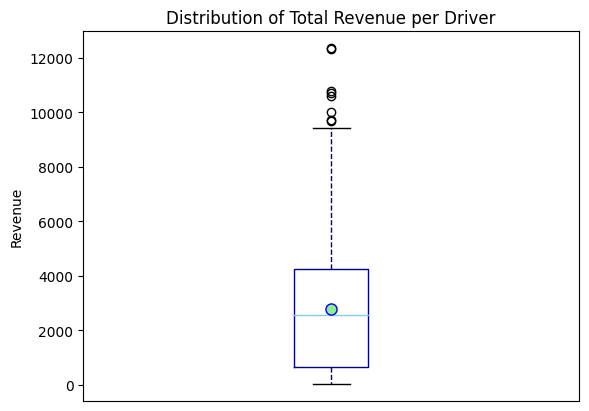

In [51]:
boxprops = dict(color='darkblue', linewidth=1)
whiskerprops = dict(linestyle='dashed', color='darkblue', linewidth=1)
medianprops = dict(color='skyblue', linewidth=1)
meanprops = dict(marker='o', markeredgecolor='blue', markerfacecolor='lightgreen', markersize=8)

plt.boxplot(total_revenue_per_driver, boxprops=boxprops, whiskerprops=whiskerprops, medianprops=medianprops, meanprops=meanprops, showmeans=True)
plt.xticks([])
plt.ylabel('Revenue')
plt.title('Distribution of Total Revenue per Driver')
plt.show()

Merge rides data

In [52]:
# pivot ride_timestamp data
ride_events = ride_timestamps.pivot(index='ride_id', columns= 'event', values='timestamp')
ride_events.head()

event,accepted_at,arrived_at,dropped_off_at,picked_up_at,requested_at
ride_id,,,,,
00003037a262d9ee40e61b5c0718f7f0,2023-10-13 09:39:51,2023-10-13 09:44:31,2023-10-13 10:03:05,2023-10-13 09:44:33,2023-10-13 09:39:19
00005eae40882760d675da5effb89ae3,2023-10-14 05:23:25,2023-10-14 05:26:17,2023-10-14 05:34:17,2023-10-14 05:26:18,2023-10-14 05:23:21
000061d42cf29f73b591041d9a1b2973,2023-10-16 15:43:14,2023-10-16 15:47:29,2023-10-16 15:54:18,2023-10-16 15:47:32,2023-10-16 15:43:09
00006efeb0d5e3ccad7d921ddeee9900,2023-10-11 19:29:43,2023-10-11 19:35:11,2023-10-11 19:40:47,2023-10-11 19:35:15,2023-10-11 19:29:36
0000d9b24d8ccdd991b76258e616fa01,2023-10-26 18:12:15,2023-10-26 18:16:52,2023-10-26 18:24:14,2023-10-26 18:16:55,2023-10-26 18:11:38


In [53]:
# merge
ride_data = pd.merge(ride_ids, ride_events, on='ride_id')
ride_data.head()

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,ride_total_cost,accepted_at,arrived_at,dropped_off_at,picked_up_at,requested_at
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,8.488488,2023-10-23 02:14:15,2023-10-23 02:16:36,2023-10-23 02:22:07,2023-10-23 02:16:40,2023-10-23 02:13:50
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,9.117306,2023-10-29 19:00:52,2023-10-29 19:03:57,2023-10-29 19:17:30,2023-10-29 19:04:01,2023-10-29 19:00:49
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,8.191174,2023-10-21 11:56:39,2023-10-21 12:01:32,2023-10-21 12:11:07,2023-10-21 12:01:35,2023-10-21 11:56:31
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,77.826485,2023-10-19 09:15:33,2023-10-19 09:18:20,2023-10-19 10:13:58,2023-10-19 09:18:20,2023-10-19 09:15:29
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,17.662788,2023-10-20 22:05:32,2023-10-20 22:07:03,2023-10-20 22:20:45,2023-10-20 22:07:02,2023-10-20 22:05:30


#### Total Number of Active Days

In [54]:
ride_data['accepted_at'] = pd.to_datetime(ride_data['accepted_at'])
ride_data['arrived_at'] = pd.to_datetime(ride_data['arrived_at'])
ride_data['dropped_off_at'] = pd.to_datetime(ride_data['dropped_off_at'])
ride_data['picked_up_at'] = pd.to_datetime(ride_data['picked_up_at'])
ride_data['requested_at'] = pd.to_datetime(ride_data['requested_at'])


In [55]:
ride_data['accepted_date'] = ride_data['accepted_at'].dt.date

In [56]:
active_days_per_driver = ride_data.groupby('driver_id')['accepted_date'].nunique()
active_days_per_driver.head()

driver_id
002be0ffdc997bd5c50703158b7c2491    30
007f0389f9c7b03ef97098422f902e62    11
011e5c5dfc5c2c92501b8b24d47509bc     9
0152a2f305e71d26cc964f8d4411add9    27
01674381af7edd264113d4e6ed55ecda    29
Name: accepted_date, dtype: int64

#### Average Revenue per Driver per Day

In [57]:
avg_revenue_per_day = round(total_revenue_per_driver / active_days_per_driver,2)

# as dataframe
avg_revenue_per_day_df = avg_revenue_per_day.reset_index()
avg_revenue_per_day_df.columns = ['driver_id', 'avg_revenue_per_day']
avg_revenue_per_day_df.head()

,driver_id,avg_revenue_per_day
0,002be0ffdc997bd5c50703158b7c2491,118.67
1,007f0389f9c7b03ef97098422f902e62,29.22
2,011e5c5dfc5c2c92501b8b24d47509bc,53.59
3,0152a2f305e71d26cc964f8d4411add9,96.67
4,01674381af7edd264113d4e6ed55ecda,185.50


In [58]:
revenue_dist =avg_revenue_per_day_df['avg_revenue_per_day'].fillna(0)

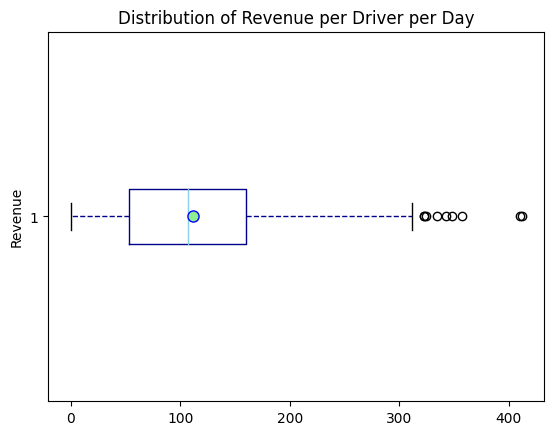

In [59]:
boxprops = dict(color='darkblue', linewidth=1)
whiskerprops = dict(linestyle='dashed', color='darkblue', linewidth=1)
medianprops = dict(color='skyblue', linewidth=1)
meanprops = dict(marker='o', markeredgecolor='blue', markerfacecolor='lightgreen', markersize=8)

plt.boxplot(revenue_dist, vert=False, boxprops=boxprops, whiskerprops=whiskerprops, medianprops=medianprops, meanprops=meanprops, showmeans=True)
#plt.xticks([])
plt.ylabel('Revenue')
plt.title('Distribution of Revenue per Driver per Day')
plt.show()

In [60]:
avg_daily_revenue_all_drivers = round(avg_revenue_per_day_df['avg_revenue_per_day'].mean(),2)
print(f'The average revenue a Uber driver brings to the company daily is ${avg_daily_revenue_all_drivers:,.2f}')

The average revenue a Uber driver brings to the company daily is $123.48


#### Average Lifespan

To calculate the average lifespan of a typical driver, that drivers who haven't given a ride recently are no longer active. In other words, the day of their last recorded ride if the day he left the app. It's a simplified assumption that may not capture the full complexity of driver engagement with the app given our limited data.

In [61]:
# find the last ride date for each driver
ride_data['dropped_off_date'] = ride_data['dropped_off_at'].dt.date
last_ride_date_per_driver = ride_data.groupby('driver_id')['dropped_off_date'].max()

# merge this information with the driver_ids dataframe
driver_ids = driver_ids.merge(last_ride_date_per_driver, on='driver_id', how='left')

In [62]:
driver_ids.head()

,driver_id,driver_onboard_date,dropped_off_date
0,002be0ffdc997bd5c50703158b7c2491,2023-03-29,2023-10-31
1,007f0389f9c7b03ef97098422f902e62,2022-03-29,2023-10-29
2,011e5c5dfc5c2c92501b8b24d47509bc,2022-04-05,2023-10-26
3,0152a2f305e71d26cc964f8d4411add9,2023-04-23,2023-10-31
4,01674381af7edd264113d4e6ed55ecda,2023-04-29,2023-10-31


In [63]:
driver_ids['driver_onboard_date'] = pd.to_datetime(driver_ids['driver_onboard_date'])
driver_ids['dropped_off_date'] = pd.to_datetime(driver_ids['dropped_off_date'])

In [64]:
# duration for each driver
driver_ids['duration_days'] = (driver_ids['dropped_off_date']-driver_ids['driver_onboard_date']).dt.days

In [65]:
driver_ids.head()

,driver_id,driver_onboard_date,dropped_off_date,duration_days
0,002be0ffdc997bd5c50703158b7c2491,2023-03-29,2023-10-31,216.0
1,007f0389f9c7b03ef97098422f902e62,2022-03-29,2023-10-29,579.0
2,011e5c5dfc5c2c92501b8b24d47509bc,2022-04-05,2023-10-26,569.0
3,0152a2f305e71d26cc964f8d4411add9,2023-04-23,2023-10-31,191.0
4,01674381af7edd264113d4e6ed55ecda,2023-04-29,2023-10-31,185.0


In [66]:
# some drivers might not have any rides, leading to NaN values in duration_days.
driver_ids['duration_days'].fillna(0, inplace=True) # assuming 0 days for drivers with no rides

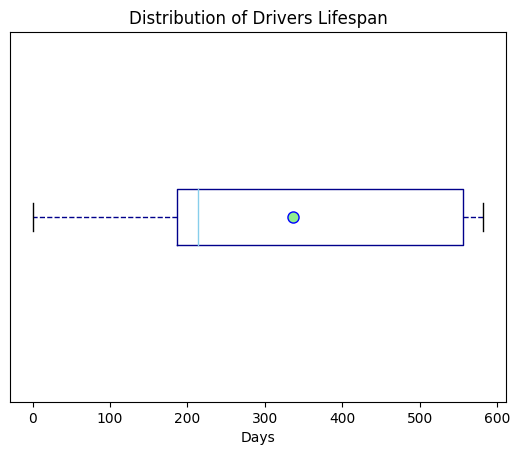

In [67]:
boxprops = dict(color='darkblue', linewidth=1)
whiskerprops = dict(linestyle='dashed', color='darkblue', linewidth=1)
medianprops = dict(color='skyblue', linewidth=1)
meanprops = dict(marker='o', markeredgecolor='blue', markerfacecolor='lightgreen', markersize=8)

plt.boxplot(driver_ids['duration_days'], vert=False, boxprops=boxprops, whiskerprops=whiskerprops, medianprops=medianprops, meanprops=meanprops, showmeans=True)
plt.yticks([])
plt.xlabel('Days')
plt.title('Distribution of Drivers Lifespan')
plt.show()

In [68]:
avg_lifespan = int(driver_ids['duration_days'].mean())
print(f'The average projected career of a driver is around {avg_lifespan} days')

The average projected career of a driver is around 336 days


#### Lifetime Value

In [69]:
ltv = avg_daily_revenue_all_drivers * avg_lifespan
print(f'The Lifetime Value of an Uber Driver is: ${ltv:,.2f}')

The Lifetime Value of an Uber Driver is: $41,489.28
